# ROB 498-004/599-004 Assignment 4-2: Vision Transformers

Before we start, please put your name and UMID in following format

: Firstname LASTNAME, #00000000   //   e.g.) Anthony OPIPARI, #12345678

**Your Answer:**   
Your NAME, #XXXXXXXX

## Setup Code
Before getting started, we need to run some boilerplate code to set up our environment, same as Assignment 1. You'll need to rerun this setup code each time you start the notebook.

First, run this cell load the autoreload extension. This allows us to edit .py source files, and re-import them into the notebook for a seamless editing and debugging experience.

In [1]:
%load_ext autoreload
%autoreload 2

### Google Colab Setup
Next we need to run a few commands to set up our environment on Google Colab. If you are running this notebook on a local machine you can skip this section.

Run the following cell to mount your Google Drive. Follow the link, sign in to your Google account (the same account you used to store this notebook!) and copy the authorization code into the text box that appears below.

In [2]:
running_colab = 'google.colab' in str(get_ipython())

if running_colab:
    from google.colab import drive
    print('Running on Colab')
    drive.mount('/content/drive/', force_remount=True)
else:
    print('Running locally')

Running locally


Now recall the path in your Google Drive where you uploaded this notebook, fill it in below. If everything is working correctly then running the folowing cell should print the filenames from the assignment:

```
["pose_estimation.ipynb", "vision_transformers.ipynb", "rob599", "pose_estimation.py", "vision_transformers.py"]
```

In [3]:
import os

# TODO: Fill in the Google Drive path where you uploaded the assignment
# Example: If you create a 2025WN folder and put all the files under P4 folder, then '2025WN/P4'
# GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = '2025WN/P4'
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = None
GOOGLE_DRIVE_PATH = './'#os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)

print(os.listdir(GOOGLE_DRIVE_PATH))

['PROPS-Pose-Dataset.tar.gz', '__pycache__', 'vision_transformers.ipynb', 'posecnn_model.pth', 'pose_cnn.py', 'rob599', 'vision_transformers.py', 'pose_estimation.ipynb', 'PROPS-Pose-Dataset']


Once you have successfully mounted your Google Drive and located the path to this assignment, run th following cell to allow us to import from the `.py` files of this assignment. If it works correctly, it should print the message:

```
Hello from convolutional_networks.py!
Hello from p4_helper.py!
```

as well as the last edit time for the file `convolutional_networks.py`.

In [4]:
import sys
sys.path.append(GOOGLE_DRIVE_PATH)

import time, os
os.environ["TZ"] = "US/Eastern"
time.tzset()

from vision_transformers import hello_vision_transformers
hello_vision_transformers()

from rob599.p4_helpers import hello_helper
hello_helper()

vision_transformers_path = os.path.join(GOOGLE_DRIVE_PATH, 'vision_transformers.py')
vision_transformers_edit_time = time.ctime(os.path.getmtime(vision_transformers_path))
print('vision_transformers.py last edited on %s' % vision_transformers_edit_time)

Hello from vision_transformers.py!
Hello from p4_helpers.py!
vision_transformers.py last edited on Thu Mar 27 13:19:29 2025


# Data preprocessing

## Setup code
Run some setup code for this notebook: Import some useful packages and increase the default figure size.

In [5]:
import rob599
import torch
import torchvision
import matplotlib.pyplot as plt
import statistics
import random
import time
import math
%matplotlib inline

from rob599 import reset_seed

plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['font.size'] = 16

Starting in this assignment, we will use the GPU to accelerate our computation. Run this cell to make sure you are using a GPU.

In [7]:
if torch.cuda.is_available():
  print('Good to go!')
else:
  print('Please set GPU via Edit -> Notebook Settings.')

Good to go!


## Load the Progress Objects dataset
We will first load the Progress Objects dataset, just as we did in previous projects. The utility function `eecs598.data.preprocess_progress_objects()` returns the entire Progress Objects dataset as a set of six **Torch tensors** while also preprocessing the RGB images:

- `X_train` contains all training images (real numbers in the range $[0, 1]$)
- `y_train` contains all training labels (integers in the range $[0, 9]$)
- `X_val` contains all validation images
- `y_val` contains all validation labels
- `X_test` contains all test images
- `y_test` contains all test labels

Downloading...
From (original): https://drive.google.com/uc?id=1C8_JFsnPVm392C-S1rH0y4HFfNkdMlXi
From (redirected): https://drive.usercontent.google.com/download?id=1C8_JFsnPVm392C-S1rH0y4HFfNkdMlXi&confirm=t&uuid=d5687038-bf48-4b09-b5f8-ae57d47d724f
To: /home/mirrorlab/Documents/higger/deeprobp4/P4/Progress-Objects-Sample.tar.gz
100%|██████████| 172M/172M [00:01<00:00, 104MB/s]  


Extracting ./Progress-Objects-Sample.tar.gz to .


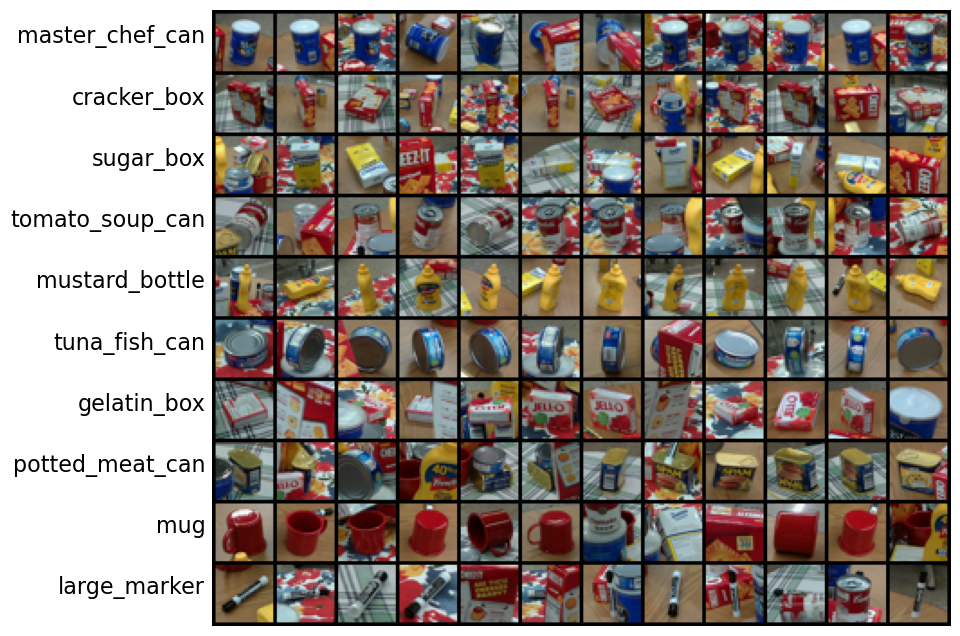

Train data shape:  torch.Size([40000, 3, 32, 32])
Train labels shape:  torch.Size([40000])
Validation data shape:  torch.Size([10000, 3, 32, 32])
Validation labels shape:  torch.Size([10000])
Test data shape:  torch.Size([10000, 3, 32, 32])
Test labels shape:  torch.Size([10000])


In [8]:
# Invoke the above function to get our data.
import rob599

rob599.reset_seed(0)
data_dict = rob599.data.preprocess_progress_objects(cuda=True, dtype=torch.float64, flatten=False)
print('Train data shape: ', data_dict['X_train'].shape)
print('Train labels shape: ', data_dict['y_train'].shape)
print('Validation data shape: ', data_dict['X_val'].shape)
print('Validation labels shape: ', data_dict['y_val'].shape)
print('Test data shape: ', data_dict['X_test'].shape)
print('Test labels shape: ', data_dict['y_test'].shape)

# Transformer networks
In the last project, we focused on convolutional networks which provided a major improvement in performance relative to compute when compared to fully-connected networks. More recently, vision transformers have proved to be useful across a range of perception tasks especially when pre-trained on large-scale datasets.

First you will implement several layer types that are used in transformer networks. You will then use these layers to train a vision transformer network on the Progress Objects dataset.

# Patchify Input Images

Unlike convolutional networks, which process input images that are shaped as 3D tensors (N,C,H,W), transformer networks expect input in the form of image patches. First, we will implement the `patchify` function in the `vision_transformers.py` file to help with image preprocessing.

In [82]:
from vision_transformers import patchify

x_shape = torch.tensor((2, 3, 4, 4))
x = torch.linspace(-0.1, 0.5, steps=torch.prod(x_shape), dtype=torch.float64, device='cuda').reshape(*x_shape)
patch_size = 2

out = patchify(x, patch_size)
correct_out = torch.tensor([[[-0.10000000,  0.00105263,  0.10210526, -0.09368421,  0.00736842,
                               0.10842105, -0.07473684,  0.02631579,  0.12736842, -0.06842105,
                               0.03263158,  0.13368421],
                             [-0.08736842,  0.01368421,  0.11473684, -0.08105263,  0.02000000,
                               0.12105263, -0.06210526,  0.03894737,  0.14000000, -0.05578947,
                               0.04526316,  0.14631579],
                             [-0.04947368,  0.05157895,  0.15263158, -0.04315789,  0.05789474,
                               0.15894737, -0.02421053,  0.07684211,  0.17789474, -0.01789474,
                               0.08315789,  0.18421053],
                             [-0.03684211,  0.06421053,  0.16526316, -0.03052632,  0.07052632,
                               0.17157895, -0.01157895,  0.08947368,  0.19052632, -0.00526316,
                               0.09578947,  0.19684211]],
                    
                            [[ 0.20315789,  0.30421053,  0.40526316,  0.20947368,  0.31052632,
                               0.41157895,  0.22842105,  0.32947368,  0.43052632,  0.23473684,
                               0.33578947,  0.43684211],
                             [ 0.21578947,  0.31684211,  0.41789474,  0.22210526,  0.32315789,
                               0.42421053,  0.24105263,  0.34210526,  0.44315789,  0.24736842,
                               0.34842105,  0.44947368],
                             [ 0.25368421,  0.35473684,  0.45578947,  0.26000000,  0.36105263,
                               0.46210526,  0.27894737,  0.38000000,  0.48105263,  0.28526316,
                               0.38631579,  0.48736842],
                             [ 0.26631579,  0.36736842,  0.46842105,  0.27263158,  0.37368421,
                               0.47473684,  0.29157895,  0.39263158,  0.49368421,  0.29789474,
                               0.39894737,  0.50000000]]],
                          dtype=torch.float64, device='cuda',
            )

# correct_out = correct_out.view([2,4,4,3])
print(correct_out.shape)
# print(out)

# Compare your output to ours; difference should be around e-8
print('Testing patchify')
print('difference: ', rob599.grad.rel_error(out, correct_out))

torch.Size([2, 4, 12])
Testing patchify
difference:  4.7368421268734195e-09


## Visualizing Image Patches

Once we have implemented our helper function, we can examine the image patch structure that will be given to our transformers using the following cell. You should see your patchified images 'align' with the input image samples.

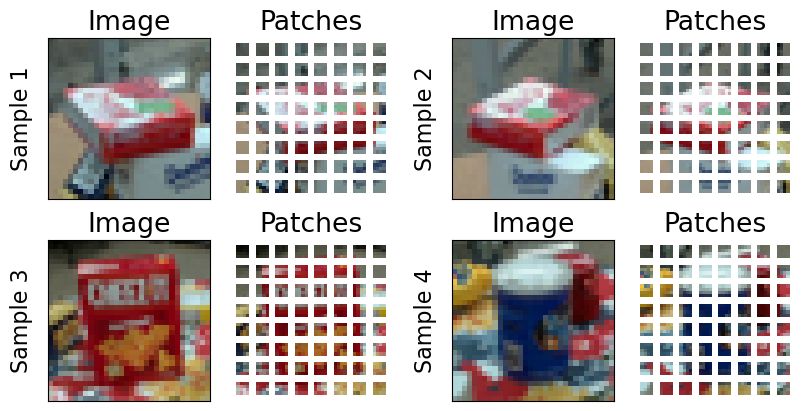

In [81]:
from vision_transformers import patchify
from rob599.utils import visualize_patches

patch_size = 4
x = data_dict['X_train'][:4]

N, C, H, W = x.shape
assert (N, C, H, W)==(4,3,32,32)


out = patchify(x, patch_size)
out = out.view(N, H//patch_size*W//patch_size, patch_size, patch_size, C)
out = out.permute(0,1,4,2,3)

fig = visualize_patches(x, out)

# Attention Layers
The attention layer was introduced by Vaswani et al. in their paper, "[Attention Is All You Need](https://arxiv.org/abs/1706.03762)" primarily as a mechanism to allow models to learn relationships across long temporal sequences in NLP. The resulting transformer architectures have drastically changed NLP and robot vision by enabling models including GPT and ViT. In the following sections, we will re-implement a [ViT model (Dosovitskiy et al.)](https://arxiv.org/abs/2010.11929) for use in object classification and self-supervised learning.

We'll start by implementing a generic attention layer in `vision_transformers.py` followed by a multi-head self-attention layer.

## Scaled Dot-Product Attention Layer

Following the definition given in Eqn. (1) from [Vaswani et al.](https://arxiv.org/abs/1706.03762), scaled dot-product attention is defined over an input query $Q\in\mathbb{R}^{P\times d_k}$, value $v\in\mathbb{R}^{n \times d_k}$, and key $k \in \mathbb{R}^{n\times d_v}$, given by:

\begin{align}
\text{Attention(Q,K,V)} = \text{softmax}(\frac{QK^{T}}{\sqrt{d_k}})V \in \mathbb{R}^{P\times d_v} \\
\end{align}

For the purpose of vision transformers, $P$ represnents the number of patches given as input to the attention layer, $d_k$ represents the input dimension of our patches as queries, and $d_v$ represents the output dimension of the layer.

To improve the performance and reduce overfitting, it is common to include a dropout layer after the attention mechanism:
\begin{align}
\text{Attention(Q,K,V)} = \text{dropout}( \text{softmax}(\frac{QK^{T}}{\sqrt{d_k}})V ) \\
\end{align}

This layer is illustrated in Figure 2 of the paper, "[Attention is All You Need](https://arxiv.org/abs/1706.03762)" by Vaswani et al. and is included below for your reference:

<div align="center">
<img src="https://deeprob.org/w25/assets/images/scaled_dot_product_attention.webp" width="400"/>
</div>

Given this context, implement the `Attention` layer class as defined in `vision_transformers.py`. Note that in this implementation we will assume that `embed_dim`$=d_k=d_v$. In addtion, note that we will use a linear projection layer on the input and output in order to have greater control on the total number of learnable parameters used by our layer.

After implementing the attention layer, run the following cell to test your implementation. You should get errors less than `1e-8`.

In [95]:
from vision_transformers import Attention

reset_seed(0)

q = torch.randn(2, 4, 4, dtype=torch.float32, device='cuda')
k = torch.randn(2, 4, 4, dtype=torch.float32, device='cuda')
v = torch.randn(2, 4, 4, dtype=torch.float32, device='cuda')

attn = Attention(embed_dim=4, hidden_dim=4)
attn = attn.cuda()

self_attn_out, self_attn_prob_out = attn(q, q, q)
attn_out, attn_prob_out = attn(q, k, v)

self_attn_correct_out = torch.tensor([[[-0.10627611, -0.62611639,  0.13222384, -1.09313488],
                                         [-0.10645102, -0.61488867,  0.10189836, -0.94813520],
                                         [ 0.07612614, -0.54552132,  0.31153607, -0.82238555],
                                         [ 0.06230495, -0.46409360, -0.03301117, -0.42071623]],
                                
                                        [[ 0.11057287, -0.39444178,  0.06920159, -0.08880806],
                                         [ 0.19311240, -0.35335156,  0.18412718, -0.29377916],
                                         [ 0.14516702, -0.35476482,  0.08905903, -0.20466976],
                                         [ 0.11944707, -0.43682113,  0.07853142, -0.28273490]]],
                               dtype=torch.float32, device='cuda',
                )
self_attn_prob_correct_out = torch.tensor([[[0.32628635, 0.25703996, 0.23558623, 0.18108749],
                                             [0.24741820, 0.26384076, 0.22483547, 0.26390556],
                                             [0.24048136, 0.42926881, 0.08706803, 0.24318181],
                                             [0.13283394, 0.34724340, 0.09205462, 0.42786804]],
                                    
                                            [[0.25455216, 0.13611786, 0.31953868, 0.28979129],
                                             [0.24402443, 0.32087967, 0.21028540, 0.22481048],
                                             [0.20070031, 0.20209791, 0.28204846, 0.31515339],
                                             [0.20488618, 0.26016372, 0.24924056, 0.28570953]]],
                                dtype=torch.float32, device='cuda',
                )
         
attn_correct_out = torch.tensor([[[ 0.05912217, -0.42211652, -0.05042682, -0.39600593],
                                 [ 0.20306754, -0.32697055,  0.13665706, -0.43784353],
                                 [ 0.20316094, -0.32098979,  0.05530454, -0.55322063],
                                 [ 0.19546732, -0.32679880,  0.05251367, -0.54702628]],
                        
                                [[-0.02486524, -0.48058981,  0.01680537, -0.85303235],
                                 [ 0.02255404, -0.59745276,  0.20221131, -0.80400515],
                                 [ 0.03725577, -0.45910370, -0.14297450, -0.65868229],
                                 [-0.04865351, -0.52705979, -0.04593496, -0.94209051]]],
                          dtype=torch.float32, device='cuda',
            )
attn_prob_correct_out = torch.tensor([[[0.20586143, 0.25646833, 0.28275558, 0.25491467],
                                         [0.22584742, 0.27487761, 0.25794467, 0.24133025],
                                         [0.37149656, 0.28244114, 0.17336245, 0.17269991],
                                         [0.36424279, 0.30884111, 0.16077881, 0.16613729]],
                                
                                        [[0.09529946, 0.20541951, 0.28147435, 0.41780668],
                                         [0.33548340, 0.25171298, 0.21469083, 0.19811280],
                                         [0.08185083, 0.23376857, 0.32362539, 0.36075523],
                                         [0.13896324, 0.26203558, 0.30177021, 0.29723096]]],
                                     dtype=torch.float32, device='cuda',
            )
                                     

# Compare your output to ours; difference should be around e-8
print('Testing Attention')
print('self-attention output difference: ', rob599.grad.rel_error(self_attn_out, self_attn_correct_out))
print('self-attention probability map difference: ', rob599.grad.rel_error(self_attn_prob_out, self_attn_prob_correct_out))
print()
print('attention output difference: ', rob599.grad.rel_error(attn_out, attn_correct_out))
print('attention probability map difference: ', rob599.grad.rel_error(attn_prob_out, attn_prob_correct_out))

Testing Attention
self-attention output difference:  3.4078962865381007e-09
self-attention probability map difference:  0.0

attention output difference:  1.97714033508005e-09
attention probability map difference:  8.916301324192009e-09


## Multi-Head Attention Layer
Next, we'll implement a multi-head attention layer in an effort to achieve more performant transformers. For multi-head attention we will split the embedding dimension, $d_{\text{model}}$, into $h$ independent sub-spaces and perform an attention layer on each of the $h$ sub-spaces in parallel before recombining the final output. This process is defined according to the following rule:

\begin{align}
\text{MultiHeadAttention(Q,K,V)} &= \text{concat} (\text{head}_1,\ldots,\text{head}_h) W^{O}\\
&\text{where} \;\; \text{head}_i = \text{dropout}( \text{softmax}(\frac{QW_{i}^{Q}{(KW_{i}^{K})}^{T}}{\sqrt{\frac{d_\text{model}}{h}}})VW_{i}^{V} )
\end{align}

Where the parameters $W_{i}^{Q}\in\mathbb{R}^{d_\text{model}\times d_k}$, $W_{i}^{K}\in\mathbb{R}^{d_\text{model}\times d_k}$, and $W_{i}^{V}\in\mathbb{R}^{d_\text{model}\times d_v}$ are learned parameter matrices that project the original input query, keys and values to the respective sub-spaces and $W^{O}\in\mathbb{R}^{h*d_{v}\times d_\text{model}}$ is a learned projection to the output space. 

This layer is illustrated in Figure 2 of the paper, "[Attention is All You Need](https://arxiv.org/abs/1706.03762)" by Vaswani et al. and is included below for your reference:

<div align="center">
<img src="https://deeprob.org/w25/assets/images/multi_head_attention.webp" width="400"/>
</div>

Now, implement the `MultiHeadAttention` layer class as defined in `vision_transformers.py`. After implementing the attention layer, run the following cell to test your implementation. You should get errors less than `1e-8`.

In [1]:
from vision_transformers import MultiHeadAttention

reset_seed(0)

q = torch.randn(2, 4, 4, dtype=torch.float32, device='cuda')
k = torch.randn(2, 4, 4, dtype=torch.float32, device='cuda')
v = torch.randn(2, 4, 4, dtype=torch.float32, device='cuda')


attn = MultiHeadAttention(embed_dim=4, hidden_dim=4, num_heads=2).to('cuda')


self_attn_out, self_attn_prob_out = attn(query=q, key=q, value=q)
attn_out, attn_prob_out = attn(query=q, key=k, value=v)

self_attn_correct_out = torch.tensor([[[ 0.14430067, -0.53784740,  0.08220236, -0.62189162],
                                         [-0.08875817, -0.63622594,  0.13209616, -0.96715879],
                                         [ 0.01958477, -0.58957678,  0.32356644, -1.08062053],
                                         [ 0.01057089, -0.44386402, -0.12629637, -0.41127431]],
                                
                                        [[ 0.08677953, -0.32324642,  0.04659149, -0.05140835],
                                         [ 0.22325052, -0.44497642,  0.25980285, -0.43782300],
                                         [ 0.22102278, -0.28993517,  0.18363853, -0.18710478],
                                         [ 0.16332752, -0.32018024,  0.12435215, -0.15900445]]],
                               dtype=torch.float32, device='cuda',
                )
self_attn_prob_correct_out = torch.tensor([[[[0.18017843, 0.20693181, 0.25834346, 0.35454631],
                                          [0.22774993, 0.22802918, 0.26726842, 0.27695245],
                                          [0.13108703, 0.37074625, 0.07695191, 0.42121479],
                                          [0.20075037, 0.39590091, 0.10477507, 0.29857367]],
                                
                                         [[0.43813339, 0.27225250, 0.19278474, 0.09682937],
                                          [0.26745394, 0.29254177, 0.19905598, 0.24094830],
                                          [0.39628604, 0.31796229, 0.16045970, 0.12529200],
                                          [0.13106003, 0.25865844, 0.14949824, 0.46078330]]],
                                
                                
                                        [[[0.15665036, 0.28312963, 0.23444588, 0.32577407],
                                          [0.37158445, 0.17279993, 0.26420507, 0.19141062],
                                          [0.12101869, 0.35739523, 0.20069814, 0.32088789],
                                          [0.17456272, 0.32275257, 0.22152309, 0.28116164]],
                                
                                         [[0.36663607, 0.08369717, 0.33788803, 0.21177872],
                                          [0.14213750, 0.45017898, 0.16196926, 0.24571429],
                                          [0.32986715, 0.11279890, 0.32183596, 0.23549798],
                                          [0.26374865, 0.19997428, 0.27420843, 0.26206869]]]],
                               dtype=torch.float32, device='cuda',
                )

attn_correct_out = torch.tensor([[[ 0.19000325, -0.40944189,  0.05954247, -0.42533216],
                                 [ 0.20030579, -0.42216203,  0.11929678, -0.35989812],
                                 [ 0.17565413, -0.31465685, -0.01690275, -0.51006687],
                                 [ 0.24779554, -0.33915606,  0.20358221, -0.29212722]],
                        
                                [[-0.07406262, -0.49398190, -0.00068270, -0.92019606],
                                 [ 0.01650470, -0.51480108, -0.18196332, -0.76464653],
                                 [ 0.03981098, -0.52065486,  0.24446507, -0.70421875],
                                 [-0.06706452, -0.51757574, -0.04265606, -0.95538819]]],
                          dtype=torch.float32, device='cuda',
            )
attn_prob_correct_out = torch.tensor([[[[0.17551190, 0.30181104, 0.27964675, 0.24303028],
                                  [0.21388243, 0.26558176, 0.26735255, 0.25318328],
                                  [0.40423116, 0.29908296, 0.14499946, 0.15168637],
                                  [0.44156876, 0.24115716, 0.14817984, 0.16909422]],
                        
                                 [[0.26640022, 0.21140006, 0.26191550, 0.26028419],
                                  [0.25274917, 0.26874062, 0.24400392, 0.23450626],
                                  [0.26538554, 0.24343665, 0.25178874, 0.23938912],
                                  [0.23541282, 0.34134340, 0.22068055, 0.20256321]]],
                        
                        
                                [[[0.06956770, 0.23741508, 0.40017304, 0.29284424],
                                  [0.47028124, 0.18850142, 0.13698901, 0.20422834],
                                  [0.06562116, 0.26101801, 0.42940381, 0.24395697],
                                  [0.15108673, 0.27565616, 0.33205390, 0.24120323]],
                        
                                 [[0.21770586, 0.18900888, 0.17506647, 0.41821879],
                                  [0.17917261, 0.29776230, 0.32718062, 0.19588445],
                                  [0.18627781, 0.20657638, 0.19890791, 0.40823790],
                                  [0.18043548, 0.24251601, 0.24581796, 0.33123049]]]],
                          dtype=torch.float32, device='cuda',
            )

print('Testing Multi-Head Attention')
print('self-attention output difference: ', rob599.grad.rel_error(self_attn_out, self_attn_correct_out))
print('self-attention probability map difference: ', rob599.grad.rel_error(self_attn_prob_out, self_attn_prob_correct_out))
print()
print('attention output difference: ', rob599.grad.rel_error(attn_out, attn_correct_out))
print('attention probability map difference: ', rob599.grad.rel_error(attn_prob_out, attn_prob_correct_out))

NameError: name 'reset_seed' is not defined

# LayerNorm
Unlike convolutional neural networks, which typically use BatchNormalization, Vision Transformers commonly rely on LayerNormalization. We'll now implement the forward and backward pass of layer normalization following its definition in the paper by Ba et al., "[Layer Normalization](https://arxiv.org/abs/1607.06450)". Please work on your implementation in the provided `LayerNorm_fn` stencil within `vision_transformers.py`.

In [ ]:
# Check the training-time forward pass by checking means and variances
# of features both before and after batch normalization
from vision_transformers import LayerNorm_fn

def print_mean_std(x,dim=0):
  means = ['%.3f' % xx for xx in x.mean(dim=dim).tolist()]
  stds = ['%.3f' % xx for xx in x.std(dim=dim).tolist()]
  print('  means: ', means)
  print('  stds:  ', stds)
  print()

# Simulate the forward pass for a two-layer network
reset_seed(0)
N, D1, D2, D3 = 2, 50, 60, 3
X = torch.randn(N, N, D1, dtype=torch.float64, device='cuda')
W1 = torch.randn(D1, D2, dtype=torch.float64, device='cuda')
W2 = torch.randn(D2, D3, dtype=torch.float64, device='cuda')
a = X.matmul(W1).clamp(min=0.).matmul(W2)

print('Before layer normalization:')
print_mean_std(a.flatten(start_dim=0, end_dim=1),dim=1)

# Run with gamma=1, beta=0. Means should be close to zero and stds close to one
gamma = torch.ones(D3, dtype=torch.float64, device='cuda')
beta = torch.zeros(D3, dtype=torch.float64, device='cuda')
print('After batch normalization (gamma=1, beta=0)')
a_norm, _ = LayerNorm_fn.forward(a, gamma, beta, {'mode': 'train'})
print_mean_std(a_norm.flatten(start_dim=0, end_dim=1),dim=1)

# Run again with nontrivial gamma and beta. Now means should be close to beta
# and std should be close to gamma.
gamma = torch.tensor([3.0, 3.0, 3.0], dtype=torch.float64, device='cuda')
beta = torch.tensor([12.0, 12.0, 12.0], dtype=torch.float64, device='cuda')
print('After batch normalization (gamma=', gamma.tolist(), ', beta=', beta.tolist(), ')')
a_norm, _ = LayerNorm_fn.forward(a, gamma, beta, {'mode': 'train'})
print_mean_std(a_norm.flatten(start_dim=0, end_dim=1),dim=1)

In [ ]:
from vision_transformers import LayerNorm_fn

# Gradient check batchnorm backward pass
reset_seed(0)
N, D = 4, 5
x = 5 * torch.randn(N, N, D, dtype=torch.float64, device='cuda') + 12
gamma = torch.randn(D, dtype=torch.float64, device='cuda')
beta = torch.randn(D, dtype=torch.float64, device='cuda')
dout = torch.randn(N, N, D, dtype=torch.float64, device='cuda')

ln_param = {'mode': 'train'}
fx = lambda x: LayerNorm_fn.forward(x, gamma, beta, ln_param)[0]
fg = lambda a: LayerNorm_fn.forward(x, a, beta, ln_param)[0]
fb = lambda b: LayerNorm_fn.forward(x, gamma, b, ln_param)[0]

dx_num = rob599.grad.compute_numeric_gradient(fx, x, dout)
da_num = rob599.grad.compute_numeric_gradient(fg, gamma.clone(), dout)
db_num = rob599.grad.compute_numeric_gradient(fb, beta.clone(), dout)

_, cache = LayerNorm_fn.forward(x, gamma, beta, ln_param)
dx, dgamma, dbeta = LayerNorm_fn.backward(dout, cache)
# You should expect to see relative errors between 1e-12 and 1e-9
print('dx error: ', rob599.grad.rel_error(dx_num, dx))
print('dgamma error: ', rob599.grad.rel_error(da_num, dgamma))
print('dbeta error: ', rob599.grad.rel_error(db_num, dbeta))

# Transformer Encoder Layer
We now have implemented all the pieces we need for a Transformer Encoder layer. For your implementation, please refer to the stencil provided in the `TransformerEncoder` class within the `vision_transformers.py` file.


<div align="center">
<img src="https://deeprob.org/w25/assets/images/vit_encoder.webp" width="200"/>
</div>


After initializing the model's parameters and implementing its forward pass, run the cell below to verify your implementation. The following cell should result in errors less than 1e-8.

In [ ]:
from vision_transformers import TransformerEncoder

reset_seed(0)

x = torch.randn(2, 4, 4, dtype=torch.float32, device='cuda')


tform = TransformerEncoder(embed_dim=4, hidden_dim=4, use_mhsa=True, num_heads=2, dropout=0.2).to('cuda')


tform_out, tform_attn_prob_out = tform(x)

tform_correct_out = torch.tensor([[[ 0.22837791,  0.48520821, -1.48722327,  0.77875745],
                                  [ 1.36270440, -0.87343740,  0.61074507, -0.73775852],
                                  [-0.63110828, -0.15224275, -0.88840133,  1.86860383],
                                  [-0.22899762, -1.44999933,  1.40524316,  0.35814071]],
                         
                                 [[-0.91953140, -0.57453340,  1.45202363, -0.22946705],
                                  [ 1.14850068, -1.10756433,  0.80179948, -0.46173581],
                                  [-0.27686939, -1.28413272,  1.62888932, -0.05994554],
                                  [ 0.19288762, -1.30245209,  1.53798258, -0.29093570]]],
                               dtype=torch.float32, device='cuda',
                )
tform_attn_prob_correct_out = torch.tensor([[[[0.24556586, 0.23461305, 0.22854063, 0.29128045],
                                               [0.26582325, 0.24528989, 0.25675115, 0.23213568],
                                               [0.16706130, 0.22485907, 0.17249395, 0.43558577],
                                               [0.13346814, 0.22852235, 0.15546216, 0.48254728]],
                                     
                                              [[0.24627049, 0.26261571, 0.23864307, 0.25247076],
                                               [0.23378015, 0.28552386, 0.21900398, 0.26169202],
                                               [0.24801090, 0.28813699, 0.21729313, 0.24655904],
                                               [0.23613985, 0.33063841, 0.18558523, 0.24763654]]],
                                     
                                     
                                             [[[0.21333496, 0.23287454, 0.26417810, 0.28961238],
                                               [0.25751153, 0.26066428, 0.24502985, 0.23679435],
                                               [0.18663345, 0.24879245, 0.26805818, 0.29651585],
                                               [0.20335537, 0.25652543, 0.26213866, 0.27798051]],
                                     
                                              [[0.21793993, 0.29064220, 0.23361358, 0.25780430],
                                               [0.19353986, 0.30574748, 0.23442140, 0.26629123],
                                               [0.18919271, 0.32504857, 0.22164042, 0.26411831],
                                               [0.18663532, 0.32387736, 0.22384013, 0.26564717]]]],
                               dtype=torch.float32, device='cuda',
                )


print('Testing Transformer Encoder')
print('transformer output difference: ', rob599.grad.rel_error(tform_out, tform_correct_out))
print('transformer probability map difference: ', rob599.grad.rel_error(tform_attn_prob_out, tform_attn_prob_correct_out))

# Vision Transformer

Next, implement the `VisionTransformer` class in `vision_transformers.py`. Before working on this implementation, consider reading the original paper, "An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale" by Dosovitskiy et al. for useful details on the model's background and implementation.

Figure 1 from the paper, "[An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale](https://arxiv.org/abs/2010.11929)" by Dosovitskiy et al., may be a helpful reference and is included below:


<div align="center">
<img src="https://deeprob.org/w25/assets/images/vit_arch.webp" width="700"/>
</div>


After initializing the model's parameters and implementing its forward pass, run the cell below to verify your implementation. The following cell should result in errors less than 1e-8.

In [ ]:
from vision_transformers import VisionTransformer

reset_seed(0)

vit_model = VisionTransformer(
        embed_dim = 8,
        hidden_dim = 8,
        num_layers = 1,
        use_mhsa = True,
        num_heads = 8,
        input_dims = (3,8,8),
        num_classes = 10,
        patch_size = 4,
        dropout = 0.1
        )
vit_model = vit_model.to('cuda')




x = torch.randn(2,3,8,8).to('cuda')
cls_tokens_out, patch_tokens_out, prob_map_out = vit_model(x)


cls_tokens_correct = torch.tensor([[-0.08487247,  0.94621676,  0.21259612,  0.99615121, -0.66612917,
                                     -0.09170625, -0.16521484,  0.41441488, -0.97881866, -0.79177248],
                                    [-0.12858473,  0.95726472,  0.16973293,  0.95529091, -0.67910570,
                                     -0.05758664, -0.11379831,  0.34818298, -1.04030991, -0.73268694]],
                                   dtype=torch.float32, device='cuda')

patch_tokens_correct = torch.tensor([[[ 0.26961550, -0.66625893, -0.41522637,  1.09102237, -0.17139906,
                                          -1.59556139,  0.07700748,  1.47457910],
                                         [ 1.40523458, -0.55241263,  0.78015375, -0.38925982,  0.67967224,
                                           1.40331721, -0.44048807, -0.76978517],
                                         [-1.71173632,  0.84137619,  0.13000342,  1.80485439, -0.11396644,
                                          -1.45090199,  0.53379393,  0.11031771],
                                         [ 1.51366949, -0.97072232, -0.78473318, -0.30233395,  0.91011310,
                                           1.24063993,  0.74257815, -0.34607267],
                                         [-1.00071716,  1.41462135,  0.41313174, -0.41611111, -1.26784325,
                                          -0.03329726, -0.10818781,  2.14279652]],
                                
                                        [[ 0.31358403, -0.59571040, -0.44242427,  1.01546955, -0.12174353,
                                          -1.58816493, -0.04374302,  1.51352358],
                                         [ 1.24628484, -0.88689780, -0.99931216, -0.23807180,  1.54572940,
                                           1.57659340, -0.45147681, -0.19232824],
                                         [ 0.95628941,  0.24360117, -0.21780124,  1.95891714, -1.38544536,
                                           0.89225626, -1.92898726,  0.06972896],
                                         [-0.54251933, -0.49246719, -0.70089996, -0.03664243,  0.96426439,
                                           2.31069112,  0.71305811, -0.53105533],
                                         [-1.62545490,  0.21655037,  0.42078006, -0.07807606, -0.81975400,
                                           0.64410102,  0.58329791,  2.14204049]]],
                                     dtype=torch.float32, device='cuda')

print('Testing Vision Transformer Model')
print('cls tokens difference: ', rob599.grad.rel_error(cls_tokens_out, cls_tokens_correct))
print('patch tokens difference: ', rob599.grad.rel_error(patch_tokens_out, patch_tokens_correct))

### Dataset Loading
We're now ready to train our very own vision transformer. The following cells will setup the necessary datasets and dataloaders for training and evaluation.

In [ ]:
# Set a few constants related to data loading.
NUM_CLASSES = 10
BATCH_SIZE = 16
PATCH_SIZE = 4

## Overfit small data
As with convolutional neural networks, a good starting point after implementing a transformer is to try training your model with just a few training samples. You should be able to overfit small datasets, which will result in very high training accuracy and comparatively low validation accuracy.

In [ ]:
from rob599 import Solver
from vision_transformers import VisionTransformer, find_overfit_parameters

reset_seed(0)

num_train = 100
small_data = {
  'X_train': data_dict['X_train'][:num_train],
  'y_train': data_dict['y_train'][:num_train],
  'X_val': data_dict['X_val'],
  'y_val': data_dict['y_val'],
}

embed_dim, hidden_dim, num_layers, use_mhsa, num_heads, weight_decay, learning_rate = find_overfit_parameters()


vit_model = VisionTransformer(
    embed_dim = embed_dim,
    hidden_dim = hidden_dim,
    num_layers = num_layers,
    use_mhsa = use_mhsa,
    num_heads = num_heads,
    input_dims = (3,32,32),
    num_classes = NUM_CLASSES,
    patch_size = PATCH_SIZE,
    dropout = 0.1
    ).to('cuda')

solver = Solver(vit_model, small_data,
                learning_rate=learning_rate,
                weight_decay=weight_decay,
                  num_epochs=50, batch_size=16,
                  print_every=100, device='cuda')
solver.train()

After running the above cell, your model should show a converged training loss with high training accuracy (100%) with low validation accuracy (below 60%).

In [ ]:
plt.title('Training losses')
plt.plot(solver.loss_history, 'o')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.gcf().set_size_inches(9, 4)
plt.show()

plt.title('Train and Val accuracies')
plt.plot(solver.train_acc_history, '-o')
plt.plot(solver.val_acc_history, '-o')
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.gcf().set_size_inches(9, 4)
plt.show()

print('Final Training Accuracy:', solver.train_acc_history[-1])
print('Final Validation Accuracy:', solver.val_acc_history[-1])

## Comparing the Use of single- and multi-head Attention
The following cell will evaluate your network on a subset of the PROPS dataset with a parameter sweep over your single and multi-head self attention layers. You should expect to see all the models achieving a >70% validation accuracy and a clear trend showing multi-head attention layers outperform the single attention layer and using more heads (up to 8) leads to higher validation accuracy.

In [ ]:
from rob599 import Solver
from vision_transformers import VisionTransformer

# Try training a ViT net with different attention methods
num_train = 10000
small_data = {
  'X_train': data_dict['X_train'][:num_train],
  'y_train': data_dict['y_train'][:num_train],
  'X_val': data_dict['X_val'],
  'y_val': data_dict['y_val'],
}

mhsa_params = [(False, 1), (True,2), (True,4), (True,8)]

solvers = []
for use_mhsa, num_heads in mhsa_params:
    vit_model = VisionTransformer(
        embed_dim = 16,
        hidden_dim = 16,
        num_layers = 1,
        use_mhsa = use_mhsa,
        num_heads = num_heads,
        input_dims = (3,32,32),
        num_classes = NUM_CLASSES,
        patch_size = PATCH_SIZE,
        dropout = 0.1
        ).to('cuda')
    
    solver = Solver(vit_model, small_data,
                  num_epochs=25, batch_size=128,
                  print_every=100, device='cuda')
    solver.train()
    solvers.append(solver)
    print()

In [ ]:
def plot_training_history_init(title, xlabel, solvers, labels, plot_fn, param_label, marker='-o'):
  plt.title(title)
  plt.xlabel(xlabel)
  for solver, label in zip(solvers, labels):
    data = plot_fn(solver)
    label = param_label + '=' + str(label)
    plt.plot(data, marker, label=label)
  plt.legend(loc='lower center', ncol=len(solvers))

plt.subplot(3, 1, 1)
plot_training_history_init('Training loss','Iteration', solvers, mhsa_params,
                            lambda x: x.loss_history, param_label='MHSA Head Params', marker='o')
plt.subplot(3, 1, 2)
plot_training_history_init('Training accuracy','Epoch', solvers, mhsa_params,
                           lambda x: x.train_acc_history, param_label='MHSA Head Params')
plt.subplot(3, 1, 3)
plot_training_history_init('Validation accuracy','Epoch', solvers, mhsa_params,
                           lambda x: x.val_acc_history, param_label='MHSA Head Params')
plt.gcf().set_size_inches(15, 25)
plt.show()

## Evaluating the Impact of Number of Layers
The following cell will evaluate your network on a subset of the PROPS dataset with a parameter sweep over the number of MHSA layers. You should expect to see all the models achieving a >80% validation accuracy and a clear trend showing models with at least four layers outperforming those with fewer as measured by validation-set accuracy.

In [ ]:
from rob599 import Solver
from vision_transformers import VisionTransformer

# Try training a ViT net with different attention methods
num_train = 10000
small_data = {
  'X_train': data_dict['X_train'][:num_train],
  'y_train': data_dict['y_train'][:num_train],
  'X_val': data_dict['X_val'],
  'y_val': data_dict['y_val'],
}

layer_params = [1, 2, 4, 8]

solvers = []
for num_layers in layer_params:
    vit_model = VisionTransformer(
        embed_dim = 16,
        hidden_dim = 16,
        num_layers = num_layers,
        use_mhsa = True,
        num_heads = 8,
        input_dims = (3,32,32),
        num_classes = NUM_CLASSES,
        patch_size = PATCH_SIZE,
        dropout = 0.1
        ).to('cuda')
    
    solver = Solver(vit_model, small_data,
                  num_epochs=25, batch_size=128,
                  print_every=100, device='cuda')
    solver.train()
    solvers.append(solver)
    print()

In [ ]:
plt.subplot(3, 1, 1)
plot_training_history_init('Training loss','Iteration', solvers, layer_params,
                            lambda x: x.loss_history, param_label='Layers', marker='o')
plt.subplot(3, 1, 2)
plot_training_history_init('Training accuracy','Epoch', solvers, layer_params,
                           lambda x: x.train_acc_history, param_label='Layers')
plt.subplot(3, 1, 3)
plot_training_history_init('Validation accuracy','Epoch', solvers, layer_params,
                           lambda x: x.val_acc_history, param_label='Layers')
plt.gcf().set_size_inches(15, 25)
plt.show()

# Train a good model!
Train the best convolutional model that you can on PROPS, storing your best model in the `best_model` variable. We require you to get at least 71% accuracy on the validation set using a convolutional net, within 60 seconds of training.

**Implement** `create_vit_solver_instance` while making sure to use the initialize your model with the input `dtype` and `device`, as well as initializing the solver on the input `device`.

In [ ]:
from vision_transformers import VisionTransformer, create_vit_solver_instance

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

solver = create_vit_solver_instance(data_dict, torch.float32, "cuda")

solver.train(time_limit=60)

# Test your model!
Run your best model on the validation and test sets. You should achieve above 71% accuracy on the validation set and 70% accuracy on the test set.

(Our best model gets 99.0% validation accuracy and 70.3% test accuracy -- can you beat ours?)

In [ ]:
print('Validation set accuracy: ', solver.check_accuracy(data_dict['X_val'], data_dict['y_val']))
print('Test set accuracy: ', solver.check_accuracy(data_dict['X_test'], data_dict['y_test']))

In [ ]:
path = os.path.join(GOOGLE_DRIVE_PATH, 'one_minute_vit.pth')
solver.model.save(path)

# Create a new instance
from vision_transformers import VisionTransformer, create_vit_solver_instance

solver = create_vit_solver_instance(data_dict, torch.float32, "cuda")

# Load model
solver.model.load(path, dtype=torch.float32, device='cuda')

# Evaluate on validation set
print('Validation set accuracy: ', solver.check_accuracy(data_dict['X_val'], data_dict['y_val']))
print('Test set accuracy: ', solver.check_accuracy(data_dict['X_test'], data_dict['y_test']))

torch.backends.cudnn.benchmark = False

# Visualizing Attention Maps
Before submitting our project, let's try to introspect our network to build an understanding of which parts of the image our vision transformer is 'attending' to when making its predictions. To do so, we will use the attnention maps returned by the network. Since each layer of our network uses self-attention, the output attention maps provide a measure of how the input feature tokens at each layer are being weighted to form the respective layers' output tokens. As a result, by taking the attention values that correspond to the output `cls_token`, we can visualize the weight given to each input tokens which provides some insight into which tokens contribute to the final prediction. In order to use this technique across multiple transformer layers, we use the Attention Rollout technique proposed by Abnar et al., which is beyond the scope of this project.

To visualize the attention maps of your trained vision transformer, we have provided all the necessary visualization code for you in the helper file `rob599.utils.py`. If you are curious, feel free to look at the `attention_rollout` function or the paper by Abnar et al., "[Quantifying Attention Flow in Transformers](https://arxiv.org/abs/2005.00928)".

In [ ]:
import numpy as np
from vision_transformers import patchify
from rob599.utils import visualize_attention

reset_seed(100)

num_samples = 4
samples = np.random.choice(data_dict['X_test'].shape[0], size=num_samples, replace=False)
x = data_dict['X_test'][samples]
y = data_dict['y_test'][samples]

N, C, H, W = x.shape
assert (N, C, H, W)==(4,3,32,32)

solver.model.eval()
out_cls, out_tokens, out_attention = solver.model(x.to(dtype=solver.model.dtype, device=solver.model.in_proj.weight.device))

fig = visualize_attention(x, out_attention, y, out_cls.argmax(dim=1))

What parts of the object is your network paying attention to most? Feel free to change the random seed to try visualizing the attention maps for different input images. How do the attention maps appear when the object is fully visible? What about under partial or full occlusion?

## Verifying notebook cells

Before moving onto the next part of the project, we can verify that no
unexpected cells have been added or removed by **saving this file** then using the following cell:

In [ ]:
from rob599.p4_helpers import verify_notebook_cells

notebook_path = os.path.join(GOOGLE_DRIVE_PATH, 'vision_transformers.ipynb')
verify_notebook_cells(notebook_path, expected_count=62)

# Submit Your Work
After completing this notebook, run the following cell to create a `.zip` file for you to download and turn in. 

**Please MANUALLY SAVE every `*.ipynb` and `*.py` files before executing the following cell:**

In [ ]:
from rob599.submit import make_p4_submission

# TODO: Replace these with your actual uniquename and umid
uniquename = None
umid = None

make_p4_submission(GOOGLE_DRIVE_PATH, uniquename, umid)

Now we can submit our project to the autograder!